# EE239AS Final Project
By: Cameron Flannery, David Martinez, Chris Chien, Peter Racioppo

Google Docs: https://docs.google.com/document/d/1Y8PA9TIpUILMhjMxly5zYrmXdbLM8vos1GWShDnRgn8/edit?usp=sharing

Overleaf Link: https://www.overleaf.com/3597713176zcvnwwnsjcmq


## Getting Started
### Mounting Google Drive to See Dataset Files
To get started, **we need to individually provide access to the dataset.** The simplest way to do this is to place the dataset files in the root directory of your google drive account.

**The cell below will allow you to mount your google drive to this project** (don't worry, only you will have access to your files). The navigation bar on the left-hand side will show you all the files that this Juypter instance can see.

The notebook's rood directory is "content" and we are mounting our google drive folders to "content/gdrive", so we expect the project files to be in the root of the "content/gdrive" directory.

Mounting the files via Google Drive will save us the pain of uploading a gigabyte worth of data every time we restart our runtime.

## Runtime

The runtime option provides access to Python 2 and 3 as well as TPU and GPUs  for processing. For this use case, since we are mostly working with pytorch and not tensorflow, I have set the hardware accelerator to GPU. I'm not sure if this change carries over to your runtime so if not, change yours to:

**Runtime Type:** Python 3 <br>
**Hardware Accelerator:** GPU

### Initializations

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as torchdata
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.set_default_tensor_type('torch.cuda.DoubleTensor')

### Helper functions

In [0]:
class Flatten(nn.Module):
  def forward(self, x):
    N, C, L = x.size()
    return x.view(N,-1)

def f_layer_size(input_size, kernel_size, padding, stride):
  """
  Parameters
  ----------
  input_size : int
  kernel_size : int
  padding : int
  stride : int
  
  Returns
  -------
  int : size of the layer output
  """
  return int((input_size-kernel_size+2*padding)/stride + 1)


def translate_labels(array, labels, to_idx=True): 
  if to_idx:
    indecies = np.zeros_like(array)
    for i, l in enumerate(labels):
      indecies[np.where(array==l)] = i
    return indecies
  
  elif to_idx is False:
    labeled = np.zeros_like(array.cpu())
    for i, l in enumerate(labels):
      labeled[np.where(array.cpu()==i)] = l
    return labeled

# -----------------------
# Gaussian Noise
def gaussian(ins, mean, stddev):
    noise = Variable(ins.data.new(ins.size()).normal_(mean, stddev))
    return noise
# -----------------------

### Loading the Data

In [5]:
os.system('clear')
# Import Data
PROJECT_ROOT = "gdrive/My Drive/"

events = {
    276:'Idling EEG (eyes open)',
    277:'Idling EEG (eyes closed)',
    768:'Start of a trial',
    769:'Cue onset left (class 1)',
    770:'Cue onset right (class 2)',
    771:'Cue onset foot (class 3)',
    772:'Cue onset tongue (class 4)',
    783:'Cue unknown',
    1023:'Rejected trial',
    1072:'Eye movements',
    32766:'Start of a new run'
}

event_labels = np.array(list(events.keys()))
output_dim = len(event_labels)

X_test = np.load(os.path.join(PROJECT_ROOT,"X_test.npy"))
y_test = np.load(os.path.join(PROJECT_ROOT,"y_test.npy"))
person_train_valid = np.load(os.path.join(PROJECT_ROOT,"person_train_valid.npy"))
X_train_valid = np.load(os.path.join(PROJECT_ROOT,"X_train_valid.npy"))
y_train_valid = np.load(os.path.join(PROJECT_ROOT,"y_train_valid.npy"))
person_test = np.load(os.path.join(PROJECT_ROOT,"person_test.npy"))

# -----------------------
# Remove EOG channels
X_test = X_test[:,0:22,:]
X_train_valid = X_train_valid[:,0:22,:]
# -----------------------

print(np.shape(X_train_valid))
# X_train_valid=np.transpose(X_train_valid,[0,2,1])
# y_train=np.transpose(y_train,[0,2,1])
# y_valid=np.transpose(y_valid,[0,2,1])
print(np.shape(X_train_valid))

# split the train_valid set into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid,
                                                      y_train_valid,
                                                      test_size=0.33,
                                                      random_state=42)


print(np.shape(X_train))

# convert to torch tensors
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(translate_labels(y_train, event_labels, to_idx=True))
X_valid_tensor = torch.from_numpy(X_valid)
y_valid_tensor = torch.from_numpy(translate_labels(y_valid, event_labels, to_idx=True))
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(translate_labels(y_test, event_labels, to_idx=True))

# Pytorch TensorDataset
train_ds = torchdata.TensorDataset(X_train_tensor, y_train_tensor)
valid_ds = torchdata.TensorDataset(X_valid_tensor, y_valid_tensor)
test_ds = torchdata.TensorDataset(X_test_tensor, y_test_tensor)
print(len(train_ds))
print(np.shape(y_train))

N, channels, steps = X_train_valid.shape
num_classes = len(events)

(2115, 22, 1000)
(2115, 22, 1000)
(1417, 22, 1000)
1417
(1417,)


In [0]:
batch_size = 64

# Pytorch DataLoader
train_loader = torchdata.DataLoader(train_ds, batch_size=batch_size, shuffle=False)
valid_loader = torchdata.DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader = torchdata.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

### Understanding the Dataset

This dataset is composed of EEG data from 25 electrodes. A detailed description of the data is found here: http://www.bbci.de/competition/iv/desc_2a.pdf

**Data Size:** There are 2115 trials; each trial has corresponding EEG data from 25 electrodes
over 1000 time bins.

Below is a simple visualization of the data from one trial. Change the trial number to see what the data looks like for different types of events.

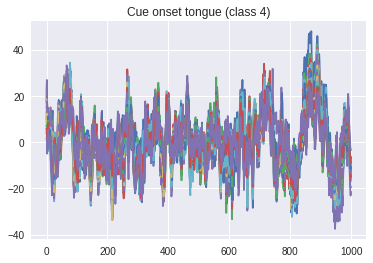

In [0]:
trial = 21
for i in range(channels):
  plt.plot(range(steps),X_train_valid[trial,i,:])

plt.title(events[y_train_valid[trial]])
plt.show()

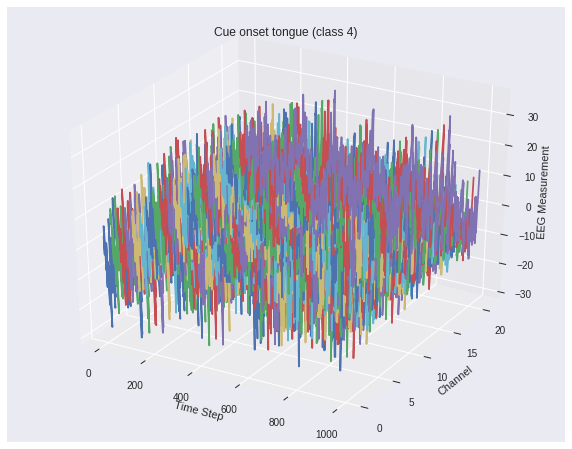

In [0]:
trial = 21

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Time Step')
ax.set_ylabel('Channel')
ax.set_zlabel('EEG Measurement')
ax.set_title(events[y_train_valid[trial]])

for i in range(channels):
  ax.plot(range(steps),np.ones(steps)*i,X_test[trial,i,:])

## Convolutional Network

### Feedforward Network

In [0]:
class CNN(nn.Module):
  """A Convolutional Neural Network designed for multichannel temporal datasets
  
  
  CNN Structure
  -------------
  input -> conv1d[0] -> relu-batchnorm -> conv1d[1] -> relu-batchnorm -> ...
    -> conv1d[n] -> relu-batchnorm -> maxpool1d -> linear activation -> output
  
  Parameters
  ----------
  input_dim : tuple (3,)
    number of samples : int
    number of channels : int
    number of time steps : int
    
  output_dim : int
    number of output features

  num_filters : int, tuple, list
    int or list of ints with the number of filters for each convolutional layer
    
    The number of convolutional filter layers depends on the number of elements
    in `num_filters`
   
  kernel_size : int, tuple, list
    int or list of ints with the kernel size for the convolutional filters
    
    Must be the same length as `num_filters`
    
  stride : int, tuple, list (optional)
    int or list of ints with the stride for the convolutional filter layers
    
    Must be the same length as `num_filters`
    
    Default: [1]*len(num_filters)
  
  padding : int, tuple, list (optional *kinda) TODO: needs generalization work
    padding for each convolutional layer
    
  pool_kernel_size : int (optional)
    The size of the pooling kernel
    
    Default: 2
    
  pool_stride : int (optional)
    The stride for the pool layers
    
    Default: 2
  """

  def __init__(self, input_dim, output_dim, num_filters, kernel_size,
               stride=None, padding=None, pool_kernel_size=2, pool_stride=2):
    super(CNN, self).__init__()

    # Input error checking
    if len(num_filters) != len(kernel_size):
      print('Error: num_filters and kernel_size must be the same length')
      exit()
    self.num_conv_filters = len(num_filters)
   
    if stride is None:
      stride = [1]*self.num_conv_filters
    elif len(num_filters) != len(stride):
      print('Error: num_filters and stride must be the same length')
      exit()

      
    if padding is None:
      padding = [0]*self.num_conv_filters
    elif len(num_filters) != len(padding):
      print('Error: num_filters and padding must be the same length')
      exit()

    self.conv = [0]*self.num_conv_filters
    self.batchnorm = [0] *self.num_conv_filters
    self.outsize = np.zeros(self.num_conv_filters)
    self.dropout=nn.Dropout(p=0.8)

    N, channels, steps = input_dim
    if type(num_filters) is list or type(num_filters) is tuple:
      for i, (f, k, s, p) in enumerate(zip(num_filters, kernel_size, stride,
                                           padding)):
        if i==0:
          self.conv[i] = nn.Conv1d(channels, f, k, stride=s, padding=p)
          # TODO: currently this doesn't take variable padding size; this could
          # lead to bugs if the kernel size and stride doesn't fit with the
          # input shape
          self.outsize[i] = f_layer_size(steps, k, p, s)

        else:
          self.conv[i] = nn.Conv1d(num_filters[i-1], f, k, stride=s, padding=p)
          self.outsize[i] = f_layer_size(self.outsize[i-1], k, p, s)
          
        self.batchnorm[i] = nn.BatchNorm1d(f)
    else:
      self.conv[0] = nn.Conv1d(channels, filter_size, kernel_size,
                               stride=stride)
      self.batchnorm[0] = nn.BatchNorm1d(filter_size)
      self.outsize[0] = f_layer_size(steps, k, p, s)
      

    self.pool = nn.MaxPool1d(kernel_size=pool_kernel_size, stride=pool_stride)
    
    linear_input_size = f_layer_size(self.outsize[-1], pool_kernel_size, 0,
                                   pool_stride)*num_filters[-1]

    self.activation = nn.Linear(linear_input_size, output_dim)

  def forward(self, x):
    for i in range(self.num_conv_filters):
      x = self.batchnorm[i](F.relu(self.conv[i](x)))
    x = self.pool(x)
    x = self.flatten(x)
    x = self.dropout(x)
    x = self.activation(x)
    return x
  
  def flatten(self, x):
    N, C, L = x.size()
    return x.view(N,-1)

In [0]:
model = None

input_dim = X_train_tensor.shape
output_dim = len(event_labels)
num_filters = [32, 128]
kernel_size = [3,5]
padding = [2, 1]

model = CNN(input_dim, output_dim, num_filters, kernel_size=kernel_size,
            padding=padding)

dtype = torch.cuda.DoubleTensor

model.type(dtype).to(device)
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(model.parameters(), lr=5e-5)

X_train_tensor = X_train_tensor.type(dtype)
y_train_tensor = y_train_tensor.type(dtype)

count = 0

loss_list = []
iteration_list = []
accuracy_list = []

valid_acc_hist = []
train_acc_hist = []

num_epochs = 30
print_every = 30
for e in range(num_epochs):
  print('Epoch: {}/{}'.format(e+1,num_epochs))
  train_total = 0
  train_correct = 0
  for i, (data, labels) in enumerate(train_loader):
#     print(i,train.size())
#     print (labels.size())
#     print (len(train_loader))
    train = Variable(data).to(device)
    labels = Variable(labels).to(device)
    # forward propagation
    y_pred = model(train)
#     print (y_pred.size(),labels.size())
    # softmax loss
    loss = loss_fn(y_pred.type(dtype), labels.long())
    
    # -----------------------
    # L1 and L2 loss
    reg_loss1 = 0.05
    reg_loss2 = 0.05
    for param in model.parameters():
      reg_loss1 += torch.sum(torch.abs(param))
      reg_loss2 += torch.sqrt(torch.sum(param**2))
    factor1 = 0.05
    factor2 = 0.05
    loss += factor1 * reg_loss1 + factor2 * reg_loss2
    # -----------------------
    
    if count % print_every == 0:
      print('loss: {}'.format(loss))
    # do backprop
    model.zero_grad()
    # calculate the gradient
    loss.backward()
    
    optimizer.step()
    
    # calculate training accuracy
    scores = F.softmax(y_pred, dim=1)
    probability, indecies = torch.max(scores,dim=1)
    train_total += labels.size(0)
    train_correct += np.sum(np.array(labels.cpu())==np.array(indecies.cpu()))
    
    count += 1
    
    if count % 10 == 0:
      # Calculate Validation Accuracy         
      correct = 0
      total = 0
      # Iterate through validation dataset
      for data, labels in valid_loader:
        data = Variable(data)
        data = data.to(device)
        labels = labels.to(device)

        # Forward propagation
        y_pred = model(data)

        # Get predictions probabilities using softmax
        scores = F.softmax(y_pred, dim=1)
        probability, indecies = torch.max(scores,dim=1)

        # Total number of labels
        total += labels.size(0)
        correct += np.sum(np.array(labels.cpu())==np.array(indecies.cpu()))
      
      valid_acc = correct / float(total)

      # store loss and iteration
      loss_list.append(loss.data)
      iteration_list.append(count)
      valid_acc_hist.append(valid_acc)
  train_acc = train_correct / float(train_total)
  train_acc_hist.append(train_acc)
  

Epoch: 1/30
loss: 72.2561404513225
Epoch: 2/30
loss: 35.69619911160305
Epoch: 3/30
loss: 13.976270532477344
Epoch: 4/30
loss: 6.51683282802747
Epoch: 5/30
Epoch: 6/30
loss: 4.269982060364893
Epoch: 7/30
loss: 3.412860041172004
Epoch: 8/30
loss: 3.0184801035622906
Epoch: 9/30
Epoch: 10/30
loss: 2.829545746685275
Epoch: 11/30
loss: 2.8794888292617262
Epoch: 12/30
loss: 2.717240823938133
Epoch: 13/30
Epoch: 14/30
loss: 2.738853754053617
Epoch: 15/30
loss: 2.723606033331689
Epoch: 16/30
loss: 2.6897570791605725
Epoch: 17/30
loss: 2.2207441692522316
Epoch: 18/30
Epoch: 19/30
loss: 2.7208331446409537
Epoch: 20/30
loss: 2.6618203874338295
Epoch: 21/30
loss: 2.6504359062197844
Epoch: 22/30
Epoch: 23/30
loss: 2.7020395865606006
Epoch: 24/30
loss: 2.6526395764033293
Epoch: 25/30
loss: 2.685105017100107
Epoch: 26/30
Epoch: 27/30
loss: 2.727090864822695
Epoch: 28/30
loss: 2.710090803875421
Epoch: 29/30
loss: 2.675730475391889
Epoch: 30/30


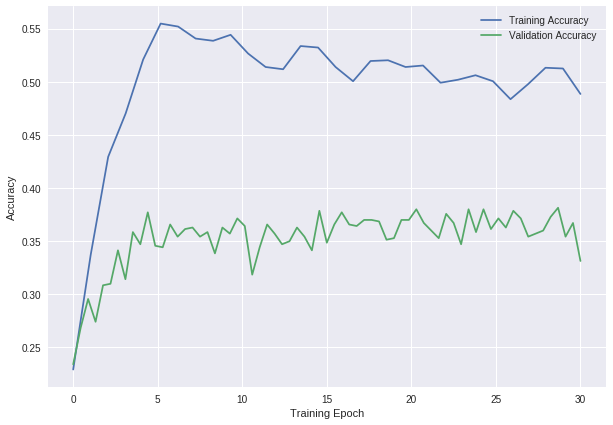

In [0]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(np.linspace(0,len(train_acc_hist),len(train_acc_hist)),train_acc_hist)
ax.plot(np.linspace(0,len(train_acc_hist),len(valid_acc_hist)),valid_acc_hist)
ax.set_xlabel('Training Epoch')
ax.set_ylabel('Accuracy')
ax.legend(['Training Accuracy','Validation Accuracy'])
plt.show()

### Testing the CNN Model

In [0]:
X_test_tensor=X_test_tensor.to(device)
y_pred=y_pred.to(device)

y_pred = model(X_test_tensor)
scores = F.softmax(y_pred, dim=1)
probability, indecies = torch.max(scores,dim=1)

yvals = translate_labels(indecies, event_labels, to_idx=False)
print('Testing accuracy: {}'.format(np.sum(yvals==y_test)/len(y_test)))

# print(np.shape(X_test_tensor))
# print(np.shape(reshape(y_test,1,len(y_test))))
# temp=np.concatenate((X_test_tensor.cpu(),reshape(y_test,1,len(y_test)), axis=0, out=None)
# print(np.shape(temp))
# # temp = [X_test_tensor y_test]
# X_test_tensor=X_test_tensor.to(device)
# y_pred=y_pred.to(device)

# y_pred = model(X_test_tensor)
# scores = F.softmax(y_pred, dim=1)
# probability, indecies = torch.max(scores,dim=1)

# yvals = translate_labels(indecies, event_labels, to_idx=False)
# print('Testing accuracy: {}'.format(np.sum(yvals==y_test)/len(y_test)))

Testing accuracy: 0.3860045146726862


## RNNs

### Elman RNN

In [0]:
class RNN(nn.Module):
  """Elman RNN model"""

  def __init__(self, input_dim, hidden_dim, output_dim=10, batch_size=64, 
               num_layers=2, permute=True, nonlinearity='tanh', dropout=0):
    super(RNN, self).__init__()
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim
    self.batch_size=batch_size
    self.num_layers = num_layers
    self.permute = permute

    _, channels, seq_len = input_dim

    # Define the RNN layer
    self.elman_rnn = nn.RNN(channels, self.hidden_dim, self.num_layers,
                      batch_first=True, nonlinearity=nonlinearity,
                      dropout=dropout)
    self.activation = nn.Linear(seq_len*self.hidden_dim,
                                self.output_dim)

  def forward(self, x):
    # We expect the data to come in the wrong order. First step is to permute.
    if self.permute:
      x = x.permute(0,2,1)
    # Forward pass through Elman RNN layer
    x, self.hidden = self.elman_rnn(x)
    x = self.flatten(x)
    x = self.activation(x)
    return x
  
  def flatten(self, x):
    N, C, L = x.size()
    return x.contiguous().view(N,-1)

In [0]:
batch_size = 32

# Pytorch DataLoader
train_loader = torchdata.DataLoader(train_ds, batch_size=batch_size, shuffle=False)
valid_loader = torchdata.DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader = torchdata.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [0]:
model = None

input_dim = X_train_tensor.shape
# note: output_dim is defined in the input cell as len(event_labels)
num_layers = 3
dropout = 0.6

model = RNN(input_dim, hidden_dim=30, output_dim=num_classes,
            batch_size=train_loader.batch_size, num_layers=num_layers,
            dropout=dropout)

dtype = torch.cuda.DoubleTensor

model.type(dtype).to(device)
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(model.parameters(), lr=5e-4, betas=(0.9, 0.999),\
                       eps=1e-08, weight_decay=0.0)
# optimizer = optim.Adam(model.parameters(), lr=6e-4,weight_decay=1e-5) # L2 reg

X_train_tensor = X_train_tensor.type(dtype)
y_train_tensor = y_train_tensor.type(dtype)

count = 0

loss_list = []
iteration_list = []
accuracy_list = []

valid_acc_hist = []
train_acc_hist = []
valid_loss_hist = []

# -----------------------
# max1 = torch.max(X_train_tensor)/30
# -----------------------

num_epochs = 40
print_every = 20
for e in range(num_epochs):
  print('Epoch: {}/{}'.format(e+1,num_epochs))
  train_total = 0
  train_correct = 0
  for i, (data, labels) in enumerate(train_loader):
    
    train = Variable(data).to(device)
    labels = Variable(labels).to(device)
    
    # -----------------------
#     noise = gaussian(train, 0, max1)
#     train += noise
    # -----------------------
   
    # forward propagation
    y_pred = model(train)
    
    # softmax loss
    loss = loss_fn(y_pred.type(dtype), labels.long())
    
    # -----------------------
    # L1 and L2 loss
    reg_loss1 = 0.0
    reg_loss2 = 0.0
    for param in model.parameters():
      reg_loss1 += torch.sum(torch.abs(param))
      reg_loss2 += torch.sqrt(torch.sum(param**2))
    factor1 = 0.005
    factor2 = 0.005
    loss += factor1 * reg_loss1 + factor2 * reg_loss2
    # -----------------------
    
    if count % print_every == 0:
      print('loss: {}'.format(loss))
    # do backprop
    model.zero_grad()
    # calculate the gradient
    loss.backward()
    
    optimizer.step()
    
    # calculate training accuracy
    scores = F.softmax(y_pred, dim=1)
    probability, indecies = torch.max(scores,dim=1)
    train_total += labels.size(0)
    train_correct += np.sum(np.array(labels.cpu())==np.array(indecies.cpu()))
    
    count += 1
    
    if count % 50 == 0:
      # Calculate Validation Accuracy         
      correct = 0
      total = 0
      # Iterate through validation dataset
      for data, labels in valid_loader:
        data = Variable(data)
        data = data.to(device)
        labels = labels.to(device)

        # Forward propagation
        y_pred = model(data)
        
        # cross entropy loss
        valid_loss = loss_fn(y_pred.type(dtype), labels.long())

        # Get predictions probabilities using softmax
        scores = F.softmax(y_pred, dim=1)
        probability, indecies = torch.max(scores,dim=1)

        # Total number of labels
        total += labels.size(0)
        correct += np.sum(np.array(labels.cpu())==np.array(indecies.cpu()))
      
      valid_acc = correct / float(total)

      # store loss and iteration
      loss_list.append(loss.data)
      iteration_list.append(count)
      valid_acc_hist.append(valid_acc)
      print('Validation Accuracy: {}'.format(valid_acc))
      valid_loss_hist.append(valid_loss.data)
  train_acc = train_correct / float(train_total)
  train_acc_hist.append(train_acc)
  

Epoch: 1/40
loss: 9.726351317364701
loss: 5.884082277804485
loss: 5.228587858594629
Epoch: 2/40
Validation Accuracy: 0.28796561604584525
loss: 4.637075925616183
loss: 4.4304294259087476
Epoch: 3/40
Validation Accuracy: 0.336676217765043
loss: 4.364429213083362
loss: 4.329615340448957
Epoch: 4/40
loss: 4.096617718088765
Validation Accuracy: 0.3667621776504298
loss: 3.841049838490818
Epoch: 5/40
loss: 3.7048277631269264
Validation Accuracy: 0.37965616045845274
loss: 3.4632026024523572
loss: 3.293368550850662
Epoch: 6/40
loss: 3.0879696896353166
Validation Accuracy: 0.4197707736389685
loss: 3.0265942873869385
Epoch: 7/40
loss: 3.14924231408342
Validation Accuracy: 0.3997134670487106
loss: 3.1042460126516476
Epoch: 8/40
loss: 3.072379658639665
loss: 2.885267815494814
Validation Accuracy: 0.3982808022922636
Epoch: 9/40
loss: 2.824541207494307
loss: 2.5863804707986366
Validation Accuracy: 0.3954154727793696
loss: 2.4509674970294015
Epoch: 10/40
loss: 2.3649281575778174
loss: 2.35453921979689

In [0]:
X_test_tensor=X_test_tensor.to(device)
y_pred=y_pred.to(device)

y_pred = model(X_test_tensor)
scores = F.softmax(y_pred, dim=1)
probability, indecies = torch.max(scores,dim=1)

yvals = translate_labels(indecies, event_labels, to_idx=False)
print('Testing accuracy: {}'.format(np.sum(yvals==y_test)/len(y_test)))

Testing accuracy: 0.42663656884875845


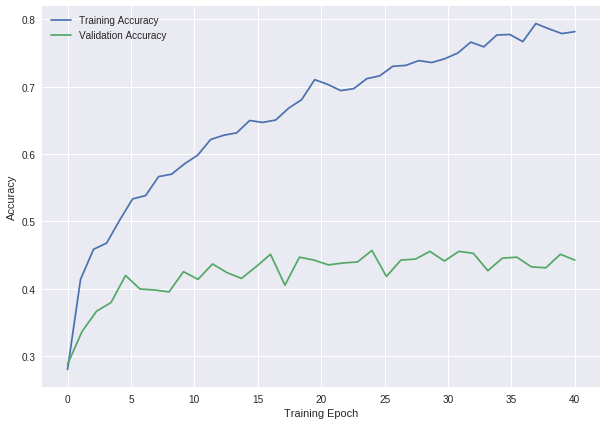

In [0]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(np.linspace(0,len(train_acc_hist),len(train_acc_hist)),train_acc_hist)
ax.plot(np.linspace(0,len(train_acc_hist),len(valid_acc_hist)),valid_acc_hist)
ax.set_xlabel('Training Epoch')
ax.set_ylabel('Accuracy')
ax.legend(['Training Accuracy','Validation Accuracy'])
plt.show()

# fig, ax = plt.subplots(1,2,figsize=(20,7))
# ax[0].plot(np.linspace(0,len(train_acc_hist),len(train_acc_hist)),train_acc_hist)
# ax[0].plot(np.linspace(0,len(train_acc_hist),len(valid_acc_hist)),valid_acc_hist)
# ax[0].set_xlabel('Training Epoch')
# ax[0].set_ylabel('Accuracy')

# ax[0].legend(['Training Accuracy','Validation Accuracy'])
# ax[0].set_title('Accuracy History')
# ax[1].plot(np.linspace(0,len(train_acc_hist),len(loss_list)),loss_list)
# ax[1].plot(np.linspace(0,len(train_acc_hist),len(valid_loss_hist)),valid_loss_hist)
# ax[1].set_xlabel('Training Epoch')
# ax[1].legend(['Training Loss','Validation Loss'])
# ax[1].set_title('Loss History')

# plt.show()

### Advanced Recurrent Models
Now lets test some more advanced RNN models that incorporate both LSTM and RNN layers.

In [0]:
class AdvancedRNN(nn.Module):
  """Advanced RNN model
  
  TODO: Currently, this only accepts one value for `hidden_dim`, which
  becomes the hidden_dimension for all the types of recurrent layers in the
  network. We should add functionality to change the order of the types
  of recurrent layers as well as their respective hidden dimensions. This
  is fairly easy to accomplish with loops and list inputs.
  """

  def __init__(self, input_dim, hidden_dim,num_layers, output_dim=10, batch_size=64, 
               permute=True, nonlinearity='tanh', dropout=0):
    
    super(AdvancedRNN, self).__init__()
    
    self.output_dim = output_dim
    self.batch_size=batch_size
    self.num_len = len(num_layers)
    self.num_layers = [0]*self.num_len
    self.hidden_dim = [0]*self.num_len
    
    for i in range(len(num_layers)):
      self.num_layers[i] = num_layers[i]
      self.hidden_dim[i] = hidden_dim[i]
    self.permute = permute

    _, channels, seq_len = input_dim

    # Define the RNN layer
    self.elman_rnn = nn.RNN(channels, self.hidden_dim[0], self.num_layers[0],
                      batch_first=True, nonlinearity=nonlinearity)
        
    self.lstm = nn.LSTM(self.hidden_dim[0], self.hidden_dim[1], self.num_layers[1],
                             batch_first=True)
    
    self.gru = nn.GRU(self.hidden_dim[0], self.hidden_dim[2], self.num_layers[2],
                             batch_first=True, dropout=dropout)

    self.activation = nn.Linear(seq_len*self.hidden_dim[2],
                                self.output_dim)
    
    self.batchnorm = nn.BatchNorm1d(seq_len)

  def forward(self, x):
    # We expect the data to come in the wrong order. First step is to permute.
    if self.permute:
      x = x.permute(0,2,1)
    # Forward pass through Elman RNN layer
    x, _ = self.elman_rnn(x)
    
    x = nn.Dropout(0.5)(x)
    x = self.batchnorm(x)
    
    # output of shape (batch, seq_len, hidden_size)
    #x, _ = self.lstm(x)
    
    
    #x = nn.Dropout(0.9)(x)
    
    
    x, _ = self.gru(x)
    x = self.flatten(x)
    x = self.activation(x)
    return x
  
  def flatten(self, x):
    N, C, L = x.size()
    return x.contiguous().view(N,-1)

In [0]:
batch_size = 40

# Pytorch DataLoader
train_loader = torchdata.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_loader = torchdata.DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader = torchdata.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [0]:
model = None

input_dim = X_train_tensor.shape
# note: output_dim is defined in the input cell as len(event_labels)
num_layers = [2,3,2]
dropout = 0
hidden_dim = [30,20,30]
num_epochs = 40

model = AdvancedRNN(input_dim, hidden_dim=hidden_dim, output_dim=num_classes,num_layers=num_layers,
                    batch_size=train_loader.batch_size, 
                    dropout=dropout)

dtype = torch.cuda.DoubleTensor

model.type(dtype).to(device)
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(model.parameters(), lr=1e-4, eps = 1e-3,weight_decay = 1e-3)

X_train_tensor = X_train_tensor.type(dtype)
y_train_tensor = y_train_tensor.type(dtype)

count = 0

loss_list = []
iteration_list = []
accuracy_list = []

valid_acc_hist = []
train_acc_hist = []  
print_every = 20
for e in range(num_epochs):
  print('Epoch: {}/{}'.format(e+1,num_epochs))
  train_total = 0
  train_correct = 0
  for i, (data, labels) in enumerate(train_loader):
    train = Variable(data).to(device)
    labels = Variable(labels).to(device)
    # forward propagation
    y_pred = model(train)
    
    # cross entropy loss
    loss = loss_fn(y_pred.type(dtype), labels.long())
    
    
    if count % print_every == 0:
      print('loss: {}'.format(loss))
    # do backprop
    model.zero_grad()
    # calculate the gradient
    loss.backward()
    
    optimizer.step()
    
    # calculate training accuracy
    scores = F.softmax(y_pred, dim=1)
    probability, indecies = torch.max(scores,dim=1)
    train_total += labels.size(0)
    train_correct += np.sum(np.array(labels.cpu())==np.array(indecies.cpu()))
    
    count += 1
    
    if count % 10 == 0:
      # Calculate Validation Accuracy         
      correct = 0
      total = 0
      # Iterate through validation dataset
      for data, labels in valid_loader:
        data = Variable(data)
        data = data.to(device)
        labels = labels.to(device)

        # Forward propagation
        y_pred = model(data)
        
        # cross entropy loss
        valid_loss = loss_fn(y_pred.type(dtype), labels.long())

        # Get predictions probabilities using softmax
        scores = F.softmax(y_pred, dim=1)
        probability, indecies = torch.max(scores,dim=1)

        # Total number of labels
        total += labels.size(0)
        correct += np.sum(np.array(labels.cpu())==np.array(indecies.cpu()))
      valid_loss_hist.append(valid_loss.data)
      valid_acc = correct / float(total)
      # store loss and iteration
      loss_list.append(loss.data)
      iteration_list.append(count)
      valid_acc_hist.append(valid_acc)
  print('Validation Accuracy: {}'.format(valid_acc))
  train_acc = train_correct / float(train_total)
  train_acc_hist.append(train_acc)

Epoch: 1/40
loss: 2.403218805092573
loss: 1.4058642404021697
Validation Accuracy: 0.2593123209169054
Epoch: 2/40
loss: 1.3713020628679886
loss: 1.336586389846784
Validation Accuracy: 0.336676217765043
Epoch: 3/40
loss: 1.2872791247622977
loss: 1.227974274593263
Validation Accuracy: 0.34813753581661894
Epoch: 4/40
loss: 1.2106937888605513
loss: 1.1084891435130473
Validation Accuracy: 0.36962750716332377
Epoch: 5/40
loss: 1.1747291807501858
Validation Accuracy: 0.37392550143266473
Epoch: 6/40
loss: 1.1562428530159918
loss: 1.1730993524842952
Validation Accuracy: 0.3853868194842407
Epoch: 7/40
loss: 1.2008619497831308
loss: 1.0579736023348327
Validation Accuracy: 0.4040114613180516
Epoch: 8/40
loss: 1.0072514307713298
loss: 0.8597734145098178
Validation Accuracy: 0.4054441260744986
Epoch: 9/40
loss: 0.9350117782890262
loss: 0.8187002791629409
Validation Accuracy: 0.41117478510028654
Epoch: 10/40
loss: 0.7746288606452416
Validation Accuracy: 0.4326647564469914
Epoch: 11/40
loss: 0.85258459

In [0]:
X_test_tensor=X_test_tensor.to(device)
y_pred=y_pred.to(device)

y_pred = model(X_test_tensor)
probability, indecies = torch.max(y_pred,dim=1)

yvals = translate_labels(indecies, event_labels, to_idx=False)
print('Testing accuracy: {}'.format(np.sum(yvals==y_test)/len(y_test)))

Testing accuracy: 0.45598194130925507


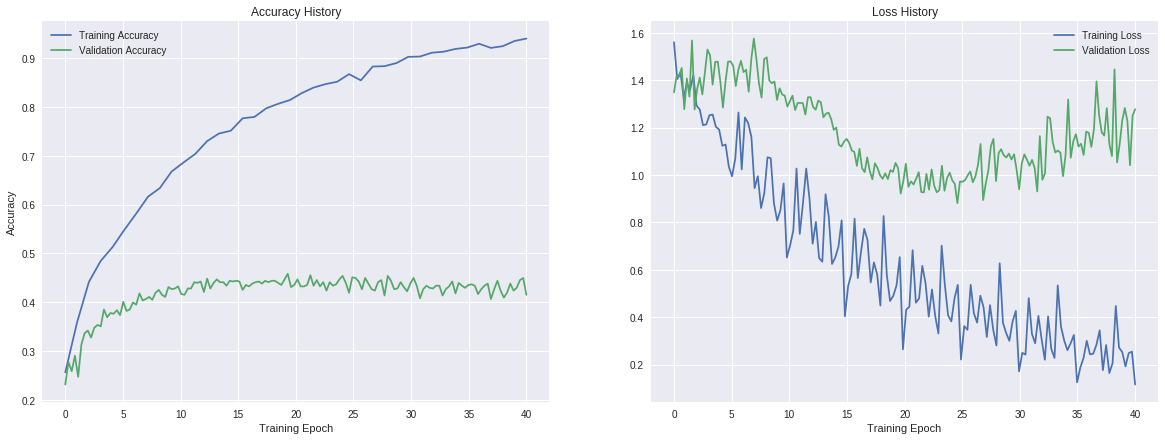

In [0]:
fig, ax = plt.subplots(1,2,figsize=(20,7))
ax[0].plot(np.linspace(0,len(train_acc_hist),len(train_acc_hist)),train_acc_hist)
ax[0].plot(np.linspace(0,len(train_acc_hist),len(valid_acc_hist)),valid_acc_hist)
ax[0].set_xlabel('Training Epoch')
ax[0].set_ylabel('Accuracy')

ax[0].legend(['Training Accuracy','Validation Accuracy'])
ax[0].set_title('Accuracy History')
ax[1].plot(np.linspace(0,len(train_acc_hist),len(loss_list)),loss_list)
ax[1].plot(np.linspace(0,len(train_acc_hist),len(valid_loss_hist)),valid_loss_hist)
ax[1].set_xlabel('Training Epoch')
ax[1].legend(['Training Loss','Validation Loss'])
ax[1].set_title('Loss History')

plt.show()

### Generalized GRU

In [0]:
class GRU2(nn.Module):
  """A Recurrent Neural Network designed for multichannel temporal datasets
  
  
  GRU Structure
  -------------
  input -> conv1d[0] -> relu-batchnorm -> conv1d[1] -> relu-batchnorm -> ...
    -> conv1d[n] -> relu-batchnorm -> maxpool1d -> linear activation -> output
  
  Parameters
  ----------
  """

  
  def __init__(self, input_dim, layer_size, num_eachlayer, int_dropouts, 
                output_dim = 10, permute=True, dropouts=0):

    super(GRU2, self).__init__()
    self.num_gru_layer = len(layer_size)
    self.gru = [0]*self.num_gru_layer
    self.dropout = [0] *self.num_gru_layer
    self.hidden = [0]*self.num_gru_layer
    self.permute = permute
    self.output_dim = output_dim
    
    
    _, channels, seq_len = input_dim
    
    
    if type(layer_size) is list:
      for i, (l, n, d, dd) in enumerate(zip(layer_size, num_eachlayer,
                                           int_dropouts,dropouts)):
        if i==0:
          self.gru[i] = nn.GRU(input_size = channels ,
                                  hidden_size = l,
                                  num_layers = n,
                                  batch_first = True,)
          self.dropout[i] = nn.Dropout(dd)

        else:
          self.gru[i] = nn.GRU(input_size = layer_size[i-1],
                                  hidden_size = l,
                                  num_layers = n,
                                  batch_first = True,)
          self.dropout[i] = nn.Dropout(dd)    
    else:
      self.gru[0] = nn.GRU(input_size = channels,
                                  hidden_size = l,
                                  num_layers = n,
                                  batch_first = True,)
      self.dropout[0] = nn.Dropout(dd)
      
      
    m = seq_len*layer_size[self.num_gru_layer - 1]
    self.activation = nn.Linear(m,self.output_dim)
    
  def forward(self, x):
    if self.permute:
      x = x.permute(0,2,1)
      
    for i in range(self.num_gru_layer):
      x, self.hidden =self.gru[i](x)
      x = self.dropout[i](x)
    x = self.flatten(x)
    x = self.activation(x)
    return x
  
  def flatten(self, x):
    N, C, L = x.size()
    return x.contiguous().view(N,-1)

In [0]:
model = None

input_dim = X_train_tensor.shape
# layer_size = [32,32]
# num_eachlayer = [2,2]
# int_drops = [0.8,0.8]
# drops = [0.8,0.8]

layer_size = [32,64]
num_eachlayer = [2,2]
int_drops = [0.8,0.8]
drops = [0.4,0.5]

# note: output_dim is defined in the input cell as len(event_labels)

model = GRU2(input_dim = input_dim , output_dim=num_classes,
                  layer_size = layer_size , num_eachlayer = num_eachlayer , 
                  int_dropouts = int_drops, dropouts = drops)

dtype = torch.cuda.DoubleTensor

model.type(dtype).to(device)
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

X_train_tensor = X_train_tensor.type(dtype)
y_train_tensor = y_train_tensor.type(dtype)

count = 0

loss_list = []
iteration_list = []
accuracy_list = []

valid_acc_hist = []
train_acc_hist = []

num_epochs = 10
print_every = 10
for e in range(num_epochs):
  print('Epoch: {}/{}'.format(e+1,num_epochs))
  train_total = 0
  train_correct = 0
  for i, (data, labels) in enumerate(train_loader):
    
    train = Variable(data).to(device)
    labels = Variable(labels).to(device)
   
    # forward propagation
    y_pred = model(train)
    
    # softmax loss
    loss = loss_fn(y_pred.type(dtype), labels.long())
    
    # -----------------------
    # L1 and L2 loss
    reg_loss1 = 0
    reg_loss2 = 0
    for param in model.parameters():
      reg_loss1 += torch.sum(torch.abs(param))
      reg_loss2 += torch.sqrt(torch.sum(param**2))
    factor1 = 0.00
    factor2 = 0.00
    loss += factor1 * reg_loss1 + factor2 * reg_loss2
    # -----------------------
    
    if count % print_every == 0:
      print('loss: {}'.format(loss))
    # do backprop
    model.zero_grad()
    # calculate the gradient
    loss.backward()
    
    optimizer.step()
    
    # calculate training accuracy
    scores = F.softmax(y_pred, dim=1)
    probability, indecies = torch.max(scores,dim=1)
    train_total += labels.size(0)
    train_correct += np.sum(np.array(labels.cpu())==np.array(indecies.cpu()))
    
    count += 1
    
    if count % 20 == 0:
      # Calculate Validation Accuracy         
      correct = 0
      total = 0
      # Iterate through validation dataset
      for data, labels in valid_loader:
        data = Variable(data)
        data = data.to(device)
        labels = labels.to(device)

        # Forward propagation
        y_pred = model(data)

        # Get predictions probabilities using softmax
        scores = F.softmax(y_pred, dim=1)
        probability, indecies = torch.max(scores,dim=1)

        # Total number of labels
        total += labels.size(0)
        correct += np.sum(np.array(labels.cpu())==np.array(indecies.cpu()))
      
      valid_acc = correct / float(total)

      # store loss and iteration
      print('Validation Accuracy: {}'.format(valid_acc))
      loss_list.append(loss.data)
      iteration_list.append(count)
      valid_acc_hist.append(valid_acc)
  train_acc = train_correct / float(train_total)
  train_acc_hist.append(train_acc)

Epoch: 1/10
loss: 2.4133641420884735
loss: 2.168761923240951
Validation Accuracy: 0.29083094555873923
loss: 1.8615038223317342
loss: 1.082729496109695
Epoch: 2/10
Validation Accuracy: 0.38825214899713467
loss: 1.0762349696683586
loss: 1.3090841788594503
Validation Accuracy: 0.35816618911174786
loss: 1.215271327253052
loss: 1.5946921723568617
Epoch: 3/10
Validation Accuracy: 0.3424068767908309
loss: 1.0759836222870103
loss: 0.993146108303959
Validation Accuracy: 0.3839541547277937
loss: 0.9694804857737956
Epoch: 4/10
loss: 0.8596456013969493
Validation Accuracy: 0.3982808022922636
loss: 0.8698225235693581
loss: 1.1151909600092718
Validation Accuracy: 0.37679083094555876
loss: 1.095317028654633
Epoch: 5/10
loss: 1.1391267776083156
Validation Accuracy: 0.3954154727793696
loss: 1.292103565703476
loss: 1.0646254090651026
Validation Accuracy: 0.38825214899713467
Epoch: 6/10
loss: 0.8483012207539271
loss: 1.0606968960173477
Validation Accuracy: 0.3753581661891118
loss: 0.8714143627188153
loss

Testing accuracy: 0.4221218961625282


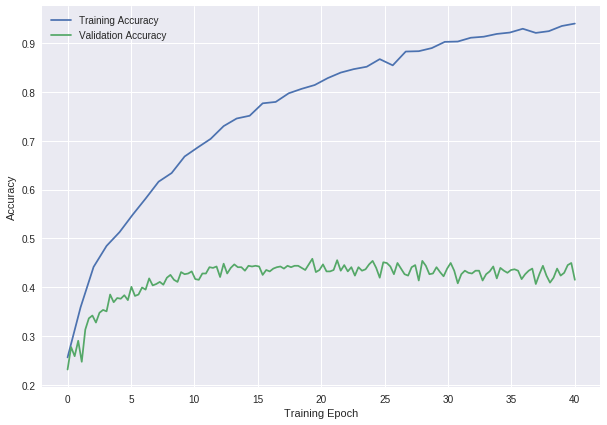

In [0]:
X_test_tensor=X_test_tensor.to(device)
y_pred=y_pred.to(device)

y_pred = model(X_test_tensor)
scores = F.softmax(y_pred, dim=1)
probability, indecies = torch.max(scores,dim=1)

yvals = translate_labels(indecies, event_labels, to_idx=False)
print('Testing accuracy: {}'.format(np.sum(yvals==y_test)/len(y_test)))

# ----------------------------

fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(np.linspace(0,len(train_acc_hist),len(train_acc_hist)),train_acc_hist)
ax.plot(np.linspace(0,len(train_acc_hist),len(valid_acc_hist)),valid_acc_hist)
ax.set_xlabel('Training Epoch')
ax.set_ylabel('Accuracy')
ax.legend(['Training Accuracy','Validation Accuracy'])
plt.show()

### Deep Learn

In [0]:
class DeepLearn(nn.Module):
  def __init__(self, input_dim, output_dim, num_filters, kernel_size,
               stride=None, padding=None, pool_kernel_size=2, pool_stride=2,
               hidden_dim=[10,10,10,10], dropout=[0,0,0,0], num_layers=[2,2,2,2],
               permute=True,nonlinearity='tanh'):
  
    # -----------------------
    # Define parameters for each layer type
    
    self.rnn1_hidden_dim = hidden_dim[0]
    self.lstm_hidden_dim = hidden_dim[1]
    self.rnn2_hidden_dim = hidden_dim[2]
    self.gru_hidden_dim  =  hidden_dim[3]
    
    self.rnn1_dropout = dropout[0]
    self.lstm_dropout = dropout[1]
    self.rnn2_dropout = dropout[2]
    self.gru_dropout  =  dropout[3]
    
    self.rnn1_num_layers = num_layers[0]
    self.lstm_num_layers = num_layers[1]
    self.rnn2_num_layers = num_layers[2]
    self.gru_num_layers  = num_layers[3]
    
    # -----------------------
    super(DeepLearn, self).__init__()
    self.output_dim = output_dim
    self.batch_size=batch_size
    self.num_layers = num_layers
    self.permute = permute
    
    _, channels, seq_len = input_dim
    
    # Input error checking
    if len(num_filters) != len(kernel_size):
      print('Error: num_filters and kernel_size must be the same length')
      exit()
    self.num_conv_filters = len(num_filters)
   
    if stride is None:
      stride = [1]*self.num_conv_filters
    elif len(num_filters) != len(stride):
      print('Error: num_filters and stride must be the same length')
      exit()

    if padding is None:
      padding = [0]*self.num_conv_filters
    elif len(num_filters) != len(padding):
      print('Error: num_filters and padding must be the same length')
      exit()

    self.conv = [0]*self.num_conv_filters
    self.batchnorm = [0] *self.num_conv_filters
    self.outsize = np.zeros(self.num_conv_filters)

    N, channels, steps = input_dim
    if type(num_filters) is list or type(num_filters) is tuple:
      for i, (f, k, s, p) in enumerate(zip(num_filters, kernel_size, stride,
                                           padding)):
        if i==0:
          self.conv[i] = nn.Conv1d(self.lstm_hidden_dim, f, k, stride=s, padding=p)
          # TODO: currently this doesn't take variable padding size; this could
          # lead to bugs if the kernel size and stride doesn't fit with the
          # input shape
          self.outsize[i] = f_layer_size(steps, k, p, s)

        else:
          self.conv[i] = nn.Conv1d(num_filters[i-1], f, k, stride=s, padding=p)
          self.outsize[i] = f_layer_size(self.outsize[i-1], k, p, s)
          
        self.batchnorm[i] = nn.BatchNorm1d(f)
    else:
      self.conv[0] = nn.Conv1d(self.lstm_hidden_dim, filter_size, kernel_size,
                               stride=stride)
      self.batchnorm[0] = nn.BatchNorm1d(filter_size)
      self.outsize[0] = f_layer_size(steps, k, p, s)
            
    self.pool = nn.MaxPool1d(kernel_size=pool_kernel_size, stride=pool_stride)

    pool_out_size = int((steps-pool_kernel_size)/pool_stride + 1)

    feature_size = num_filters[-1]
  
    # Define the RNN layer
    self.elman_rnn1 = nn.RNN(channels, self.rnn1_hidden_dim, self.rnn1_num_layers,
                      batch_first=True, dropout=self.rnn1_dropout, nonlinearity=nonlinearity)
   
    self.elman_rnn2 = nn.RNN(feature_size, self.rnn2_hidden_dim, self.rnn2_num_layers,
                      batch_first=True, dropout=self.rnn2_dropout, nonlinearity=nonlinearity)
        
    self.lstm = nn.LSTM(self.rnn1_hidden_dim, self.lstm_hidden_dim, self.lstm_num_layers,
                             dropout=self.lstm_dropout, batch_first=True)
    
    self.gru = nn.GRU(self.rnn2_hidden_dim, self.gru_hidden_dim, self.gru_num_layers,
                             batch_first=True, dropout=self.gru_dropout)

    self.activation = nn.Linear(self.gru_hidden_dim*pool_out_size, self.output_dim)

# Start:  batch, channel, seq_len
# --> len_seq, batch, channel
# --> batch, channel, len_seq
  def forward(self, x):
    
    # Permute
    if self.permute:
      x = x.permute(0,2,1)
    # Elman RNN + LSTM
    x, _ = self.elman_rnn1(x)
    x, _ = self.lstm(x)
    # Unpermute
    if self.permute:
      x = x.permute(0,2,1)
    # n CNN layers
    for i in range(self.num_conv_filters):
      x = self.batchnorm[i](F.relu(self.conv[i](x)))
    x = self.pool(x)
    # Permute again
    if self.permute:
      x = x.permute(0,2,1)
   # RNN + GRU
    x, _ = self.elman_rnn2(x)
    x, _ = self.gru(x)
    x = self.flatten(x)
    x = self.activation(x)
    return x

  def flatten(self, x):
    N, C, L = x.size()
    return x.contiguous().view(N,-1)
  

In [0]:
# ------------------
# Model Params
num_filters = [32, 50, 50, 50, 50]
kernel_size = [5, 9, 5, 5, 5]
padding = [2, 4, 2, 2, 2]
hidden_dim = [15, 15, 15, 15]
num_layers = [1,1,1,1]
dropout = [0.2,0.2,0.2,0.2]
# -------------------

model = None

input_dim = X_train_tensor.shape
output_dim = len(event_labels)

model = DeepLearn(input_dim, hidden_dim=hidden_dim, output_dim=num_classes,
                  num_filters = num_filters, kernel_size=kernel_size,
                  padding=padding,num_layers=num_layers,dropout=dropout)

dtype = torch.cuda.DoubleTensor

model.type(dtype).to(device)
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

X_train_tensor = X_train_tensor.type(dtype)
y_train_tensor = y_train_tensor.type(dtype)

count = 0

loss_list = []
iteration_list = []
accuracy_list = []

valid_acc_hist = []
train_acc_hist = []

num_epochs = 10
print_every = 10
for e in range(num_epochs):
  print('Epoch: {}/{}'.format(e+1,num_epochs))
  train_total = 0
  train_correct = 0
  for i, (data, labels) in enumerate(train_loader):

    train = Variable(data).to(device)
    labels = Variable(labels).to(device)
   
    # forward propagation
    y_pred = model(train)
    
    # softmax loss
    loss = loss_fn(y_pred.type(dtype), labels.long())
    
    # -----------------------
    # L1 and L2 loss
    reg_loss1 = 0
    reg_loss2 = 0
    for param in model.parameters():
      reg_loss1 += torch.sum(torch.abs(param))
      reg_loss2 += torch.sqrt(torch.sum(param**2))
    factor1 = 0.005
    factor2 = 0.005
    loss += factor1 * reg_loss1 + factor2 * reg_loss2
    # -----------------------
    
    if count % print_every == 0:
      print('loss: {}'.format(loss))
    # do backprop
    model.zero_grad()
    # calculate the gradient
    loss.backward()
    
    optimizer.step()
    
    # calculate training accuracy
    scores = F.softmax(y_pred, dim=1)
    probability, indecies = torch.max(scores,dim=1)
    train_total += labels.size(0)
    train_correct += np.sum(np.array(labels.cpu())==np.array(indecies.cpu()))
    
    count += 1
    
    if count % 50 == 0:
      # Calculate Validation Accuracy         
      correct = 0
      total = 0
      # Iterate through validation dataset
      for data, labels in valid_loader:
        data = Variable(data)
        data = data.to(device)
        labels = labels.to(device)

        # Forward propagation
        y_pred = model(data)

        # Get predictions probabilities using softmax
        scores = F.softmax(y_pred, dim=1)
        probability, indecies = torch.max(scores,dim=1)

        # Total number of labels
        total += labels.size(0)
        correct += np.sum(np.array(labels.cpu())==np.array(indecies.cpu()))
      
      valid_acc = correct / float(total)

      # store loss and iteration
      loss_list.append(loss.data)
      iteration_list.append(count)
      valid_acc_hist.append(valid_acc)
  train_acc = train_correct / float(train_total)
  train_acc_hist.append(train_acc)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Epoch: 1/10
loss: 8.173791954068383
loss: 6.566981750188872
loss: 5.80137687956925
loss: 5.3767260316137415
Epoch: 2/10
loss: 4.922773520892576
loss: 4.7851645054703615
loss: 4.612304666264795
loss: 4.482158239396577
Epoch: 3/10
loss: 4.36043698241015
loss: 4.298295868066409
loss: 4.165246864217986
Epoch: 4/10
loss: 4.018897147878144
loss: 3.94215359403385
loss: 3.8065405436336457
loss: 3.8140104398649157
Epoch: 5/10
loss: 3.7085375886276797
loss: 3.7390682666309782
loss: 3.815307651497664
Epoch: 6/10
loss: 3.598064059797168
loss: 3.506424715341711
loss: 3.5155851427970712
loss: 3.417838234733461
Epoch: 7/10
loss: 3.3814536740449896
loss: 3.318173847289446
loss: 3.289833379886443
loss: 3.130536914920592
Epoch: 8/10
loss: 3.058134630664312
loss: 3.0523429961530812
loss: 2.907195060936937
Epoch: 9/10
loss: 2.851994922841233
loss: 2.8162615841501895
loss: 2.6681077814339185
loss: 2.6879548148589607
Epoch: 10/10
loss: 2.646747224059352
loss: 2.7335333485165227
loss: 2.8349471878675634


Testing accuracy: 0.34988713318284426


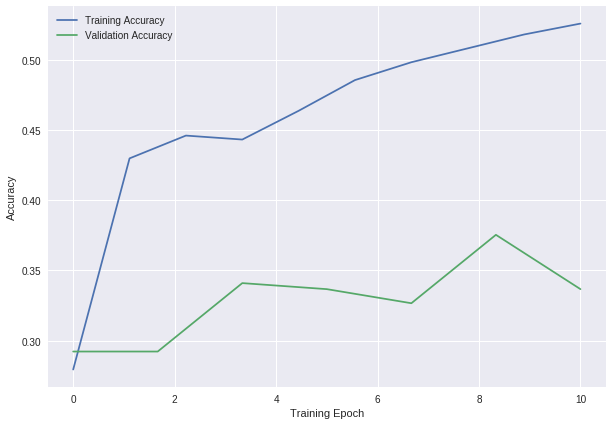

In [0]:
X_test_tensor=X_test_tensor.to(device)
y_pred=y_pred.to(device)

y_pred = model(X_test_tensor)
scores = F.softmax(y_pred, dim=1)
probability, indecies = torch.max(scores,dim=1)

yvals = translate_labels(indecies, event_labels, to_idx=False)
print('Testing accuracy: {}'.format(np.sum(yvals==y_test)/len(y_test)))

# ----------------------------

fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(np.linspace(0,len(train_acc_hist),len(train_acc_hist)),train_acc_hist)
ax.plot(np.linspace(0,len(train_acc_hist),len(valid_acc_hist)),valid_acc_hist)
ax.set_xlabel('Training Epoch')
ax.set_ylabel('Accuracy')
ax.legend(['Training Accuracy','Validation Accuracy'])
plt.show()

### EEGNet1

In [0]:
class EEGNet1(nn.Module):

  def __init__(self, input_dim, hidden_dim, output_dim=10,
               num_layers=2, permute=True, dropout=0):
    super(EEGNet1, self).__init__()
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim
    self.num_layers = num_layers
    self.permute = permute
    
    _, channels, seq_len = input_dim
    
    
    self.conv1 = nn.Conv2d(in_channels=1,
                           out_channels=1,
                           kernel_size=(3,3))
    
    eeg_channels = f_layer_size(channels, 3, 0, 1)
    seq_len_size = f_layer_size(seq_len, 3, 0, 1)
    self.pool1 = nn.MaxPool2d(kernel_size=(2,2),
                              stride=None,
                              padding=0)
    
    self.dropout1 = nn.Dropout2d(p=0.25)
    
    self.batchnorm1 = nn.BatchNorm2d(1)
    
    eeg_channels = f_layer_size(eeg_channels, 2, 0, 2)
    seq_len_size = f_layer_size(seq_len_size, 2, 0, 2)   

    self.conv2 = nn.Conv1d(in_channels=eeg_channels,
                           out_channels=eeg_channels,
                           kernel_size=10,
                           stride=1,
                           padding=0)
    
    
    
    
    out_length = f_layer_size(seq_len_size, 10, 0, 1)
    self.batchnorm2 = nn.BatchNorm1d(eeg_channels)
    
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()
    # Define the LSTM layer
    self.lstm = nn.LSTM(eeg_channels, self.hidden_dim, self.num_layers,
                        batch_first=True, dropout=dropout)
    
    self.activation = nn.Linear(out_length*self.hidden_dim,
                                self.output_dim)

  def forward(self, x):
    # add another column to the data to allow for 2d processing
    x = x[:,None,:,:]
    x = self.dropout1(self.pool1(self.relu(self.conv1(x))))
    x = self.batchnorm1(x)
    N, C, W, H = x.shape
    x = x.reshape((N,W,H))
    x = self.tanh(self.conv2(x))   
    x = self.batchnorm2(x)
    # We expect the data to come in the wrong order. First step is to permute.
    if self.permute:
      x = x.permute(0,2,1)
    # Forward pass through LSTM layer
    x, self.hidden = self.lstm(x)
    x = self.flatten(x)
    x = self.activation(self.tanh(x))
    return x
  
  def flatten(self, x):
    N, C, L = x.size()
    return x.contiguous().view(N,-1)

In [52]:
# initialize training
model = None

input_dim = X_train_tensor.shape
# note: output_dim is defined in the input cell as len(event_labels)
num_layers = 2
dropout = 0.25
hidden_dim = 12

model = EEGNet1(input_dim, hidden_dim=hidden_dim, output_dim=num_classes,
                num_layers=num_layers, dropout=dropout)

dtype = torch.cuda.DoubleTensor

model.type(dtype).to(device)
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-2)

X_train_tensor = X_train_tensor.type(dtype)
y_train_tensor = y_train_tensor.type(dtype)

count = 0

loss_list = []
valid_loss_hist = []
iteration_list = []
accuracy_list = []

valid_acc_hist = []
train_acc_hist = []


num_epochs = 100
print_every = 10
for e in range(num_epochs):
  print('Epoch: {}/{}'.format(e+1,num_epochs))
  train_total = 0
  train_correct = 0
  for i, (data, labels) in enumerate(train_loader):
    train = Variable(data).to(device)
    labels = Variable(labels).to(device)
    # forward propagation
    y_pred = model(train)
    
    # cross entropy loss
    loss = loss_fn(y_pred.type(dtype), labels.long())
    
    if count % print_every == 0:
      print('loss: {}'.format(loss))
    # do backprop
    model.zero_grad()
    # calculate the gradient
    loss.backward()
    
    optimizer.step()
    
    # calculate training accuracy
    scores = F.softmax(y_pred, dim=1)
    probability, indecies = torch.max(scores,dim=1)
    train_total += labels.size(0)
    train_correct += np.sum(np.array(labels.cpu())==np.array(indecies.cpu()))
    
    count += 1
    
    if count % 10 == 0:
      # Calculate Validation Accuracy         
      correct = 0
      total = 0
      # Iterate through validation dataset
      for data, labels in valid_loader:
        data = Variable(data)
        data = data.to(device)
        labels = labels.to(device)

        # Forward propagation
        y_pred = model(data)
        
        # cross entropy loss
        valid_loss = loss_fn(y_pred.type(dtype), labels.long())

        # Get predictions probabilities using softmax
        scores = F.softmax(y_pred, dim=1)
        probability, indecies = torch.max(scores,dim=1)

        # Total number of labels
        total += labels.size(0)
        correct += np.sum(np.array(labels.cpu())==np.array(indecies.cpu()))
      valid_loss_hist.append(valid_loss.data)
      valid_acc = correct / float(total)
      # store loss and iteration
      loss_list.append(loss.data)
      iteration_list.append(count)
      valid_acc_hist.append(valid_acc)
  print('Validation Accuracy: {}'.format(valid_acc))
  train_acc = train_correct / float(train_total)
  train_acc_hist.append(train_acc)

Epoch: 1/100
loss: 2.387290726933148
loss: 2.0989256654985824
loss: 1.8859867045614114
Validation Accuracy: 0.2335243553008596
Epoch: 2/100
loss: 1.727142178012743
loss: 1.6254038968417823
Validation Accuracy: 0.22779369627507162
Epoch: 3/100
loss: 1.5682444523029826
loss: 1.510647435458325
Validation Accuracy: 0.22779369627507162
Epoch: 4/100
loss: 1.4908132221133152
loss: 1.4662764389893936
loss: 1.4581544600106247
Validation Accuracy: 0.22636103151862463
Epoch: 5/100
loss: 1.4473796567135269
loss: 1.441192012328571
Validation Accuracy: 0.22636103151862463
Epoch: 6/100
loss: 1.4287660997800544
loss: 1.4298954778801711
Validation Accuracy: 0.22636103151862463
Epoch: 7/100
loss: 1.4265056230001434
loss: 1.4167779472056148
loss: 1.4130642996947933
Validation Accuracy: 0.22636103151862463
Epoch: 8/100
loss: 1.4164523747703006
loss: 1.413587474536007
Validation Accuracy: 0.22636103151862463
Epoch: 9/100
loss: 1.4019337559467355
loss: 1.4055650124021366
Validation Accuracy: 0.2263610315186

### EEGNet2

In [0]:
class EEGNet2(nn.Module):
  """Same as EEGNet1, but backwards.
  
  input -> lstm -> droput -> conv1d -> maxpool -> relu-batchnorm -> conv2d ->
  relu-batchnorm -> linear -> output
  """
  def __init__(self, input_dim, hidden_dim, output_dim=10,
               num_layers=2, permute=True, dropout=0, conv1_filters=20):
    super(EEGNet2, self).__init__()
    self.hidden_dim = hidden_dim
    self.output_dim = output_dim
    self.num_layers = num_layers
    self.permute = permute
    
    _, channels, seq_len = input_dim
    
    
    # Define the LSTM layer
    self.lstm = nn.LSTM(channels, self.hidden_dim, self.num_layers,
                        batch_first=True, dropout=dropout)
    
    self.conv1 = nn.Conv1d(in_channels=self.hidden_dim,
                           out_channels=conv1_filters,
                           kernel_size=10,
                           stride=1,
                           padding=0)
    
    seq_len_size = f_layer_size(seq_len, 10, 0, 1)
    
    self.pool1 = nn.MaxPool1d(kernel_size=2,
                              stride=None,
                              padding=0)
    
    seq_len_size = f_layer_size(seq_len_size, 2, 0, 2)
    
    self.batchnorm1 = nn.BatchNorm1d(conv1_filters)
    
    self.conv2 = nn.Conv2d(in_channels=1,
                           out_channels=1,
                           kernel_size=(3,3))
    
    eeg_channels = f_layer_size(conv1_filters, 3, 0, 1)
    seq_len_size = f_layer_size(seq_len_size, 3, 0, 1)

    self.pool2 = nn.MaxPool2d(kernel_size=(2,2),
                              stride=None,
                              padding=0)

    eeg_channels = f_layer_size(eeg_channels, 2, 0, 2)
    seq_len_size = f_layer_size(seq_len_size, 2, 0, 2)    
    
    self.batchnorm2 = nn.BatchNorm2d(1)

    self.linear = nn.Linear(seq_len_size*eeg_channels,output_dim)

    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()
    

  def forward(self, x):
    
    """input -> lstm -> droput -> conv1d -> relu-batchnorm -> conv2d ->
    relu-batchnorm -> linear -> output"""
    # We expect the data to come in the wrong order. First step is to permute.
    if self.permute:
      x = x.permute(0,2,1)
    x, hidden = self.lstm(x)
    if self.permute:
      x = x.permute(0,2,1)
      
    x = self.conv1(x)
    x = self.relu(self.pool1(x))
    x = self.batchnorm1(x)
    
    x = x[:,None,:,:]
    x = self.conv2(x)
    x = self.batchnorm2(self.relu(self.pool2(x)))
    
    N, C, W, H = x.shape
    x = x.reshape((N,W,H))

    x = self.flatten(x)
    x = self.linear(x)
    return x
  
  def flatten(self, x):
    N, C, L = x.size()
    return x.contiguous().view(N,-1)

In [54]:
# initialize training
model = None

input_dim = X_train_tensor.shape
# note: output_dim is defined in the input cell as len(event_labels)
num_layers = 2
dropout = 0.5
hidden_dim = 8

model = EEGNet2(input_dim, hidden_dim=hidden_dim, output_dim=num_classes,
                num_layers=num_layers, conv1_filters=50)

dtype = torch.cuda.DoubleTensor

model.type(dtype).to(device)
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-2)

X_train_tensor = X_train_tensor.type(dtype)
y_train_tensor = y_train_tensor.type(dtype)

count = 0

loss_list = []
valid_loss_hist = []
iteration_list = []
accuracy_list = []

valid_acc_hist = []
train_acc_hist = []


num_epochs = 100
print_every = 10
for e in range(num_epochs):
  print('Epoch: {}/{}'.format(e+1,num_epochs))
  train_total = 0
  train_correct = 0
  for i, (data, labels) in enumerate(train_loader):
    train = Variable(data).to(device)
    labels = Variable(labels).to(device)
    # forward propagation
    y_pred = model(train)
    
    # cross entropy loss
    loss = loss_fn(y_pred.type(dtype), labels.long())
    
    if count % print_every == 0:
      print('loss: {}'.format(loss))
    # do backprop
    model.zero_grad()
    # calculate the gradient
    loss.backward()
    
    optimizer.step()
    
    # calculate training accuracy
    scores = F.softmax(y_pred, dim=1)
    probability, indecies = torch.max(scores,dim=1)
    train_total += labels.size(0)
    train_correct += np.sum(np.array(labels.cpu())==np.array(indecies.cpu()))
    
    count += 1
    
    if count % 10 == 0:
      # Calculate Validation Accuracy         
      correct = 0
      total = 0
      # Iterate through validation dataset
      for data, labels in valid_loader:
        data = Variable(data)
        data = data.to(device)
        labels = labels.to(device)

        # Forward propagation
        y_pred = model(data)
        
        # cross entropy loss
        valid_loss = loss_fn(y_pred.type(dtype), labels.long())

        # Get predictions probabilities using softmax
        scores = F.softmax(y_pred, dim=1)
        probability, indecies = torch.max(scores,dim=1)

        # Total number of labels
        total += labels.size(0)
        correct += np.sum(np.array(labels.cpu())==np.array(indecies.cpu()))
      valid_loss_hist.append(valid_loss.data)
      valid_acc = correct / float(total)
      # store loss and iteration
      loss_list.append(loss.data)
      iteration_list.append(count)
      valid_acc_hist.append(valid_acc)
  print('Validation Accuracy: {}'.format(valid_acc))
  train_acc = train_correct / float(train_total)
  train_acc_hist.append(train_acc)

Epoch: 1/100
loss: 2.41946380243092
loss: 1.8080059123744248
loss: 1.4885429111908248
Validation Accuracy: 0.27507163323782235
Epoch: 2/100
loss: 1.4431665289516402
loss: 1.4145541546256777
Validation Accuracy: 0.3022922636103152
Epoch: 3/100
loss: 1.3798295121738495
loss: 1.3465952353711976
Validation Accuracy: 0.30659025787965616
Epoch: 4/100
loss: 1.2993288050236729
loss: 1.2801512169849738
loss: 1.2613492085039952
Validation Accuracy: 0.3123209169054441
Epoch: 5/100
loss: 1.2845715185680944
loss: 1.3034631060649706
Validation Accuracy: 0.30659025787965616
Epoch: 6/100
loss: 1.18834541154772
loss: 1.1931355340465992
Validation Accuracy: 0.31805157593123207
Epoch: 7/100
loss: 1.156139947292242
loss: 1.2712399538804078
loss: 0.539383184366862
Validation Accuracy: 0.3223495702005731
Epoch: 8/100
loss: 1.1537437841424476
loss: 1.1058340345135333
Validation Accuracy: 0.3223495702005731
Epoch: 9/100
loss: 1.1781380556677552
loss: 1.0843489366613235
Validation Accuracy: 0.332378223495702
E

### CNN2D

In [0]:
class CNN2D(nn.Module):


  def __init__(self, input_dim, pool_kernel_size, num_filters_1, num_filters_2, conv1d_filter_1,Linear_size,conv1d_filter_2,conv1d_filter_3,
               stride=None, padding=None, pool_stride=2):
    super(CNN2D, self).__init__()

      
    self.conv2d1 = nn.Conv2d(in_channels=1,
                           out_channels=num_filters_1,
                           kernel_size=(1,10)) 
    
    self.batchnorm1 = nn.BatchNorm2d(num_filters_1)
    
    
    
    self.conv2d2 = nn.Conv3d(in_channels=1,
                           out_channels=num_filters_2,
                           kernel_size=(num_filters_1,22,1)) 
    
    self.pooling1 =  nn.MaxPool2d (kernel_size=pool_kernel_size) 
    
    self.batchnorm2 = nn.BatchNorm1d(num_filters_2)
    
    
    self.conv1d1 = nn.Conv1d(num_filters_2, conv1d_filter_1, 10)
    self.batchnorm3 = nn.BatchNorm1d(conv1d_filter_1)
    self.pooling2 =  nn.MaxPool2d (kernel_size=pool_kernel_size)
    
    self.conv1d2 = nn.Conv1d(conv1d_filter_1, conv1d_filter_2, 10)
    self.batchnorm4 = nn.BatchNorm1d(conv1d_filter_2)
    #self.pooling3 =  nn.MaxPool2d (kernel_size=pool_kernel_size)
    
    self.conv1d3 = nn.Conv1d(conv1d_filter_2, conv1d_filter_3, 10)
    self.batchnorm5 = nn.BatchNorm1d(conv1d_filter_3)
    #self.pooling4 = nn.MaxPool2d (kernel_size=pool_kernel_size)
    
    self.activation = nn.Linear(Linear_size, output_dim)
    
    self.tanh = nn.Tanh()
      
  def forward(self, x):
    x = x[:,None,:,:]
    x = self.conv2d1(x)
    x = self.tanh(x)
    x = self.batchnorm1(x)
    
    x = x[:,None,:,:,:]
    x = self.conv2d2(x)
    
    
    x = nn.Dropout(0.5)(x)
    
    
    N, C, W, H, L = x.shape
    x = x.reshape((N,C,L))
    
    x = self.batchnorm2(self.tanh(x))
    
    x = x.permute(0,2,1)
    x = self.pooling1(x)
    x = x.permute(0,2,1)
    
    x = self.conv1d1(x)
    x = self.batchnorm3(self.tanh(x))
    x = x.permute(0,2,1)
    x = self.pooling2(x)
    x = x.permute(0,2,1)
    
    x = self.batchnorm4(F.relu(self.conv1d2(x)))
    x = x.permute(0,2,1)
    x = self.pooling2(x)
    x = x.permute(0,2,1)
    
    
    x = nn.Dropout(0.8)(x)
    
    
    x = self.batchnorm5(F.relu(self.conv1d3(x)))
    x = x.permute(0,2,1)
    x = self.pooling2(x)
    x = x.permute(0,2,1)
    
    
    
    x = self.flatten(x)
    x = self.activation(x)
    return x
  
  def flatten(self, x):
    N, C, L = x.size()
    return x.contiguous().view(N,-1)

In [58]:
model = None

input_dim = X_train_tensor.shape
pool_kernel_size = (3,1)
output_dim = len(event_labels)

padding = [2,2,1]
num_epochs = 80

num_filters_1 = 35
num_filters_2 = 30
conv1d_filter_1 = 80
conv1d_filter_2 = 130
conv1d_filter_3 = 180
Linear_size = 1260

model = CNN2D(input_dim, pool_kernel_size, num_filters_1 = num_filters_1, num_filters_2 = num_filters_2,Linear_size = Linear_size,
              conv1d_filter_1 = conv1d_filter_1,conv1d_filter_2=conv1d_filter_2, conv1d_filter_3 = conv1d_filter_3,
            padding=padding)

dtype = torch.cuda.DoubleTensor

model.type(dtype).to(device)
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-1, eps = 1e-3)

X_train_tensor = X_train_tensor.type(dtype)
y_train_tensor = y_train_tensor.type(dtype)

count = 0

loss_list = []
valid_loss_hist = []
iteration_list = []
accuracy_list = []

valid_acc_hist = []
train_acc_hist = []

print_every = 100
for e in range(num_epochs):
  print('Epoch: {}/{}'.format(e+1,num_epochs))
  train_total = 0
  train_correct = 0
  for i, (data, labels) in enumerate(train_loader):
    train = Variable(data).to(device)
    labels = Variable(labels).to(device)
    # forward propagation
    y_pred = model(train)
    
    # cross entropy loss
    loss = loss_fn(y_pred.type(dtype), labels.long())
    
    
    if count % print_every == 0:
      print('loss: {}'.format(loss))
    # do backprop
    model.zero_grad()
    # calculate the gradient
    loss.backward()
    
    optimizer.step()
    
    # calculate training accuracy
    scores = F.softmax(y_pred, dim=1)
    probability, indecies = torch.max(scores,dim=1)
    train_total += labels.size(0)
    train_correct += np.sum(np.array(labels.cpu())==np.array(indecies.cpu()))
    
    count += 1
    
    if count % 10 == 0:
      # Calculate Validation Accuracy         
      correct = 0
      total = 0
      # Iterate through validation dataset
      for data, labels in valid_loader:
        data = Variable(data)
        data = data.to(device)
        labels = labels.to(device)

        # Forward propagation
        y_pred = model(data)
        
        # cross entropy loss
        valid_loss = loss_fn(y_pred.type(dtype), labels.long())

        # Get predictions probabilities using softmax
        scores = F.softmax(y_pred, dim=1)
        probability, indecies = torch.max(scores,dim=1)

        # Total number of labels
        total += labels.size(0)
        correct += np.sum(np.array(labels.cpu())==np.array(indecies.cpu()))
      valid_loss_hist.append(valid_loss.data)
      valid_acc = correct / float(total)
      # store loss and iteration
      loss_list.append(loss.data)
      iteration_list.append(count)
      valid_acc_hist.append(valid_acc)
  print('Validation Accuracy: {}'.format(valid_acc))
  train_acc = train_correct / float(train_total)
  train_acc_hist.append(train_acc)

Epoch: 1/80
loss: 2.5960969655494113
Validation Accuracy: 0.28939828080229224
Epoch: 2/80
Validation Accuracy: 0.2979942693409742
Epoch: 3/80
Validation Accuracy: 0.28796561604584525
Epoch: 4/80
Validation Accuracy: 0.32664756446991405
Epoch: 5/80
loss: 1.36596609820477
Validation Accuracy: 0.30945558739255014
Epoch: 6/80
Validation Accuracy: 0.3438395415472779
Epoch: 7/80
Validation Accuracy: 0.3624641833810888
Epoch: 8/80
Validation Accuracy: 0.3681948424068768
Epoch: 9/80
loss: 1.2966500568365105
Validation Accuracy: 0.3853868194842407
Epoch: 10/80
Validation Accuracy: 0.3853868194842407
Epoch: 11/80
Validation Accuracy: 0.4040114613180516
Epoch: 12/80
Validation Accuracy: 0.40830945558739257
Epoch: 13/80
Validation Accuracy: 0.40114613180515757
Epoch: 14/80
loss: 1.1656526640484697
Validation Accuracy: 0.4154727793696275
Epoch: 15/80
Validation Accuracy: 0.40257879656160456
Epoch: 16/80
Validation Accuracy: 0.43123209169054444
Epoch: 17/80
Validation Accuracy: 0.4469914040114613
Ep

Testing accuracy: 0.600451467268623


Text(0.5, 1.0, 'Loss History')

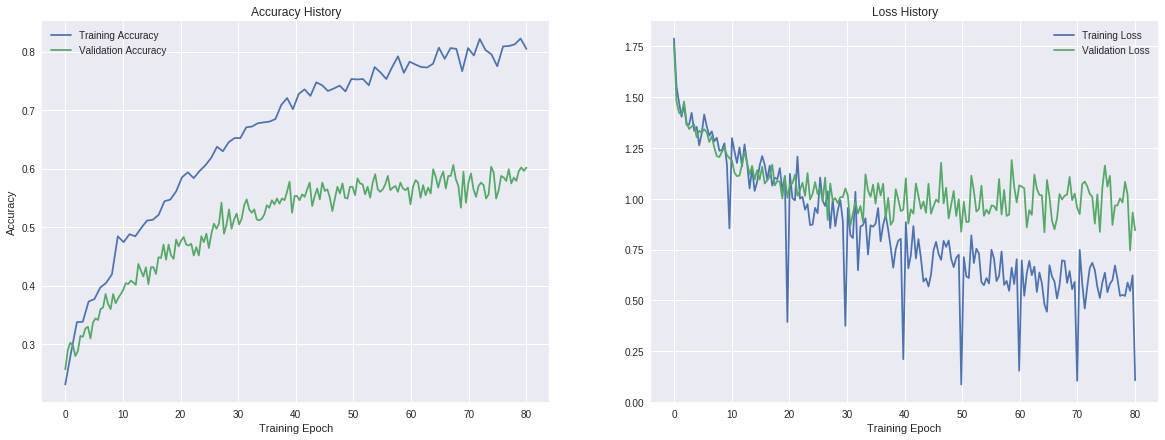

In [59]:
X_test_tensor=X_test_tensor.to(device)
y_pred=y_pred.to(device)

y_pred = model(X_test_tensor)
probability, indecies = torch.max(y_pred,dim=1)

yvals = translate_labels(indecies, event_labels, to_idx=False)
print('Testing accuracy: {}'.format(np.sum(yvals==y_test)/len(y_test)))


fig, ax = plt.subplots(1,2,figsize=(20,7))
ax[0].plot(np.linspace(0,len(train_acc_hist),len(train_acc_hist)),train_acc_hist)
ax[0].plot(np.linspace(0,len(train_acc_hist),len(valid_acc_hist)),valid_acc_hist)
ax[0].set_xlabel('Training Epoch')
ax[0].set_ylabel('Accuracy')

ax[0].legend(['Training Accuracy','Validation Accuracy'])
ax[0].set_title('Accuracy History')
ax[1].plot(np.linspace(0,len(train_acc_hist),len(loss_list)),loss_list)
ax[1].plot(np.linspace(0,len(train_acc_hist),len(valid_loss_hist)),valid_loss_hist)
ax[1].set_xlabel('Training Epoch')
ax[1].legend(['Training Loss','Validation Loss'])
ax[1].set_title('Loss History')


### Sample Cutting Method CNN2D

In [0]:
time_steps200 = 250
time_steps500 = 250
time_steps700 = 700
batch_size = 20


X_train_tensor_200 = X_train_tensor[:,:,0:time_steps200]
X_test_tensor_200 = X_test_tensor[:,:,0:time_steps200]
X_valid_tensor_200 = X_valid_tensor[:,:,0:time_steps200]
# Pytorch TensorDataset
train_ds_200 = torchdata.TensorDataset(X_train_tensor_200, y_train_tensor)
valid_ds_200 = torchdata.TensorDataset(X_valid_tensor_200, y_valid_tensor)
test_ds_200 = torchdata.TensorDataset(X_test_tensor_200, y_test_tensor)
# Pytorch DataLoader
train_loader_200 = torchdata.DataLoader(train_ds_200, batch_size=batch_size, shuffle=True)
valid_loader_00 = torchdata.DataLoader(valid_ds_200, batch_size=batch_size, shuffle=True)
test_loader_00 = torchdata.DataLoader(test_ds_200, batch_size=batch_size, shuffle=False)



X_train_tensor_500 = X_train_tensor[:,:,0:time_steps500]
X_test_tensor_500 = X_test_tensor[:,:,0:time_steps500]
X_valid_tensor_500 = X_valid_tensor[:,:,0:time_steps500]
# Pytorch TensorDataset
train_ds_500 = torchdata.TensorDataset(X_train_tensor_500, y_train_tensor)
valid_ds_500 = torchdata.TensorDataset(X_valid_tensor_500, y_valid_tensor)
test_ds_500 = torchdata.TensorDataset(X_test_tensor_500, y_test_tensor)
# Pytorch DataLoader
train_loader_500 = torchdata.DataLoader(train_ds_500, batch_size=batch_size, shuffle=True)
valid_loader_500 = torchdata.DataLoader(valid_ds_500, batch_size=batch_size, shuffle=True)
test_loader_500 = torchdata.DataLoader(test_ds_500, batch_size=batch_size, shuffle=False)


X_train_tensor_700 = X_train_tensor[:,:,0:time_steps700]
X_test_tensor_700 = X_test_tensor[:,:,0:time_steps700]
X_valid_tensor_700 = X_valid_tensor[:,:,0:time_steps700]
# Pytorch TensorDataset
train_ds_700 = torchdata.TensorDataset(X_train_tensor_700, y_train_tensor)
valid_ds_700 = torchdata.TensorDataset(X_valid_tensor_700, y_valid_tensor)
test_ds_700 = torchdata.TensorDataset(X_test_tensor_700, y_test_tensor)
# Pytorch DataLoader
train_loader_700 = torchdata.DataLoader(train_ds_700, batch_size=batch_size, shuffle=True)
valid_loader_700 = torchdata.DataLoader(valid_ds_700, batch_size=batch_size, shuffle=True)
test_loader_700 = torchdata.DataLoader(test_ds_700, batch_size=batch_size, shuffle=False)

In [12]:
model = None

input_dim = X_train_tensor.shape
pool_kernel_size = (3,1)
output_dim = len(event_labels)

padding = [2,2,1]
num_epochs = 80

num_filters_1 = 35
num_filters_2 = 30
conv1d_filter_1 = 80
conv1d_filter_2 = 130
conv1d_filter_3 = 180
Linear_size = 1260

model = CNN2D(input_dim, pool_kernel_size, num_filters_1 = num_filters_1, num_filters_2 = num_filters_2,Linear_size = Linear_size,
              conv1d_filter_1 = conv1d_filter_1,conv1d_filter_2=conv1d_filter_2, conv1d_filter_3 = conv1d_filter_3,
            padding=padding)

dtype = torch.cuda.DoubleTensor

model.type(dtype).to(device)
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-1, eps = 1e-3)

X_train_tensor = X_train_tensor.type(dtype)
y_train_tensor = y_train_tensor.type(dtype)

count = 0

loss_list = []
valid_loss_hist = []
iteration_list = []
accuracy_list = []

valid_acc_hist = []
train_acc_hist = []

print_every = 100
for e in range(num_epochs):
  print('Epoch: {}/{}'.format(e+1,num_epochs))
  train_total = 0
  train_correct = 0
  for i, (data, labels) in enumerate(train_loader):
    train = Variable(data).to(device)
    labels = Variable(labels).to(device)
    # forward propagation
    y_pred = model(train)
    
    # cross entropy loss
    loss = loss_fn(y_pred.type(dtype), labels.long())
    
    
    if count % print_every == 0:
      print('loss: {}'.format(loss))
    # do backprop
    model.zero_grad()
    # calculate the gradient
    loss.backward()
    
    optimizer.step()
    
    # calculate training accuracy
    scores = F.softmax(y_pred, dim=1)
    probability, indecies = torch.max(scores,dim=1)
    train_total += labels.size(0)
    train_correct += np.sum(np.array(labels.cpu())==np.array(indecies.cpu()))
    
    count += 1
    
    if count % 10 == 0:
      # Calculate Validation Accuracy         
      correct = 0
      total = 0
      # Iterate through validation dataset
      for data, labels in valid_loader:
        data = Variable(data)
        data = data.to(device)
        labels = labels.to(device)

        # Forward propagation
        y_pred = model(data)
        
        # cross entropy loss
        valid_loss = loss_fn(y_pred.type(dtype), labels.long())

        # Get predictions probabilities using softmax
        scores = F.softmax(y_pred, dim=1)
        probability, indecies = torch.max(scores,dim=1)

        # Total number of labels
        total += labels.size(0)
        correct += np.sum(np.array(labels.cpu())==np.array(indecies.cpu()))
      valid_loss_hist.append(valid_loss.data)
      valid_acc = correct / float(total)
      # store loss and iteration
      loss_list.append(loss.data)
      iteration_list.append(count)
      valid_acc_hist.append(valid_acc)
  print('Validation Accuracy: {}'.format(valid_acc))
  train_acc = train_correct / float(train_total)
  train_acc_hist.append(train_acc)

Epoch: 1/80
loss: 2.4761985776124664
Validation Accuracy: 0.2994269340974212
Epoch: 2/80
Validation Accuracy: 0.2607449856733524
Epoch: 3/80
Validation Accuracy: 0.30802292263610315
Epoch: 4/80
Validation Accuracy: 0.3123209169054441
Epoch: 5/80
loss: 1.3213673511679425
Validation Accuracy: 0.336676217765043
Epoch: 6/80
Validation Accuracy: 0.33810888252148996
Epoch: 7/80
Validation Accuracy: 0.3681948424068768
Epoch: 8/80
Validation Accuracy: 0.3438395415472779
Epoch: 9/80
loss: 1.2357192445179128
Validation Accuracy: 0.37965616045845274
Epoch: 10/80
Validation Accuracy: 0.40974212034383956
Epoch: 11/80
Validation Accuracy: 0.4183381088825215
Epoch: 12/80
Validation Accuracy: 0.40114613180515757
Epoch: 13/80
Validation Accuracy: 0.40830945558739257
Epoch: 14/80
loss: 1.1343744287342976
Validation Accuracy: 0.4183381088825215
Epoch: 15/80
Validation Accuracy: 0.42120343839541546
Epoch: 16/80
Validation Accuracy: 0.4512893982808023
Epoch: 17/80
Validation Accuracy: 0.4326647564469914
Ep

Testing accuracy: 0.5665914221218962


Text(0.5, 1.0, 'Loss History')

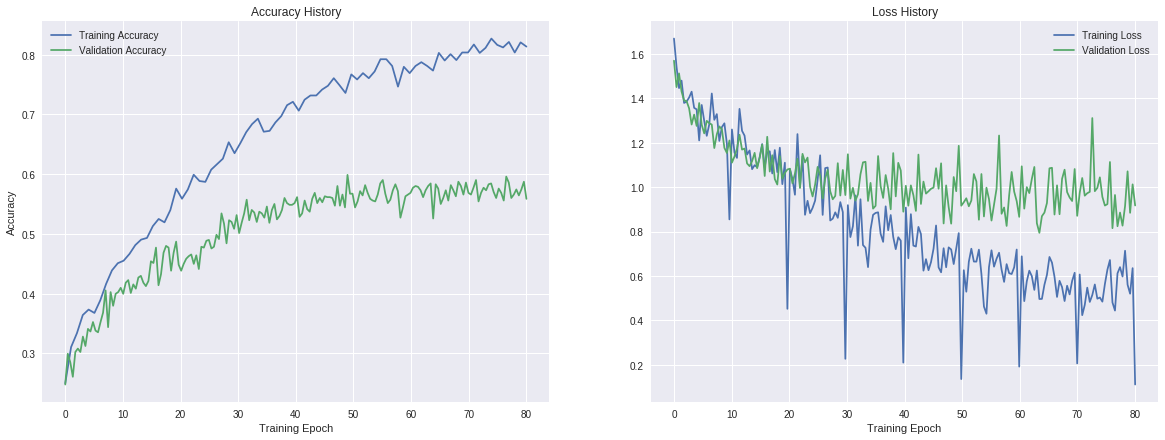

In [13]:
X_test_tensor=X_test_tensor.to(device)
y_pred=y_pred.to(device)

y_pred = model(X_test_tensor)
probability, indecies = torch.max(y_pred,dim=1)

yvals = translate_labels(indecies, event_labels, to_idx=False)
print('Testing accuracy: {}'.format(np.sum(yvals==y_test)/len(y_test)))


fig, ax = plt.subplots(1,2,figsize=(20,7))
ax[0].plot(np.linspace(0,len(train_acc_hist),len(train_acc_hist)),train_acc_hist)
ax[0].plot(np.linspace(0,len(train_acc_hist),len(valid_acc_hist)),valid_acc_hist)
ax[0].set_xlabel('Training Epoch')
ax[0].set_ylabel('Accuracy')

ax[0].legend(['Training Accuracy','Validation Accuracy'])
ax[0].set_title('Accuracy History')
ax[1].plot(np.linspace(0,len(train_acc_hist),len(loss_list)),loss_list)
ax[1].plot(np.linspace(0,len(train_acc_hist),len(valid_loss_hist)),valid_loss_hist)
ax[1].set_xlabel('Training Epoch')
ax[1].legend(['Training Loss','Validation Loss'])
ax[1].set_title('Loss History')